# Setup environment

In [1]:
%matplotlib inline

In [2]:
# In case of plotly not showing the charts run!
import plotly.io as pio
pio.renderers.default='notebook'

## Functions

In [3]:
import numpy as np
import pandas as pd
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sksurv.metrics import cumulative_dynamic_auc

def evaluate_model(model,X_train,T_train, E_train,X_test,T_test,E_test,
                   c_index=True,ibs=True,c_auc=True):

    # c-index
    if c_index:
        from pysurvival.utils.metrics import concordance_index
        c_index = concordance_index(model, X_test, T_test, E_test)
        print('c-index: {0:5.4f}'.format(c_index))
    else:
        c_index=0

    # ibs
    if ibs:        
        from pysurvival.utils.display import integrated_brier_score
        ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=200,
                    figure_size=(20, 6.5) )
        print('IBS: {0:5.4f}'.format(ibs))
    else:
        ibs=0

    # cumulative_auc
    if c_auc:
        from sksurv.metrics import cumulative_dynamic_auc

        train = np.array([(e,t) for e,t in zip(E_train,T_train)],dtype=[('event', 'bool_'),('time','int_')])
        test = np.array([(e,t) for e,t in zip(E_test,T_test)],dtype=[('event', 'bool_'),('time','int_')])

        # auc does not support inf risk so we replace with a really large value
        risk = model.predict_risk(X_test)
        risk = np.where(risk == np.inf,100,risk)

        auc_time_list,mean_auc = cumulative_dynamic_auc(train, test, risk, [100,150,300,500], tied_tol=1e-08)
        print('AUC: {0:5.4f}'.format(mean_auc))
    else:
        mean_auc=0

    #return results
    results = pd.DataFrame({'c_index':[c_index],
                                'ibs':[ibs],
                                'mean_auc':[mean_auc]})
    return results

# Get Data


In [4]:
import pandas as pd

# Get train data
X_train= pd.read_csv('data/X_train_20200206.csv')
T_train= pd.read_csv('data/T_train_20200206.csv',names=['time'])
T_train = T_train['time']
E_train= pd.read_csv('data/E_train_20200206.csv',names=['event'])
E_train = E_train['event']

# Gest test data
X_test= pd.read_csv('data/X_test_20200206.csv')
T_test= pd.read_csv('data/T_test_20200206.csv',names=['time'])
T_test = T_test['time']
E_test= pd.read_csv('data/E_test_20200206.csv',names=['event'])
E_test = E_test['event']

# Hyperparameters tunning

## num_trees

Number of trees that will be built in the forest.

**Best Results: num_trees = 75**

FIT MODEL WITH PARAMETERS
num_trees: 25
c-index: 0.7471


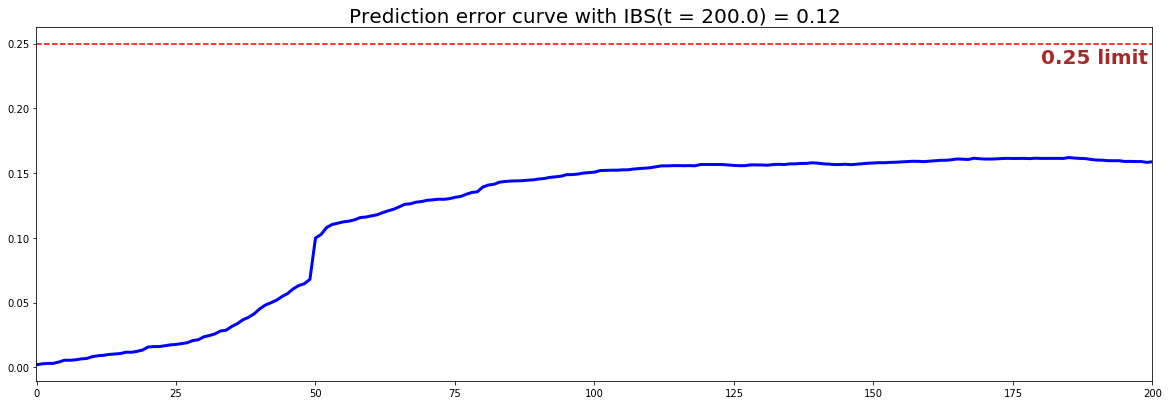

IBS: 0.1182
AUC: 0.8416
FIT MODEL WITH PARAMETERS
num_trees: 75


/home/marcosmedvescig/tesis/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




c-index: 0.7520


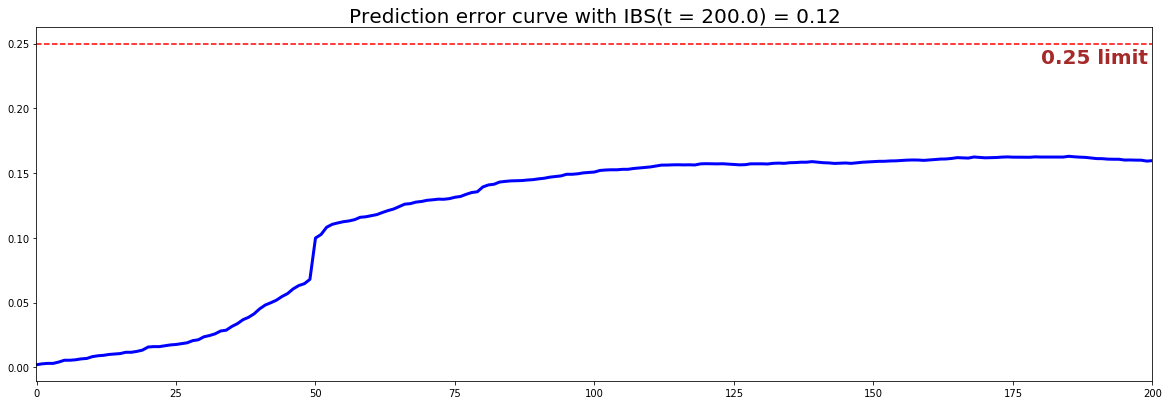

IBS: 0.1186
AUC: 0.8453
FIT MODEL WITH PARAMETERS
num_trees: 100
c-index: 0.7512


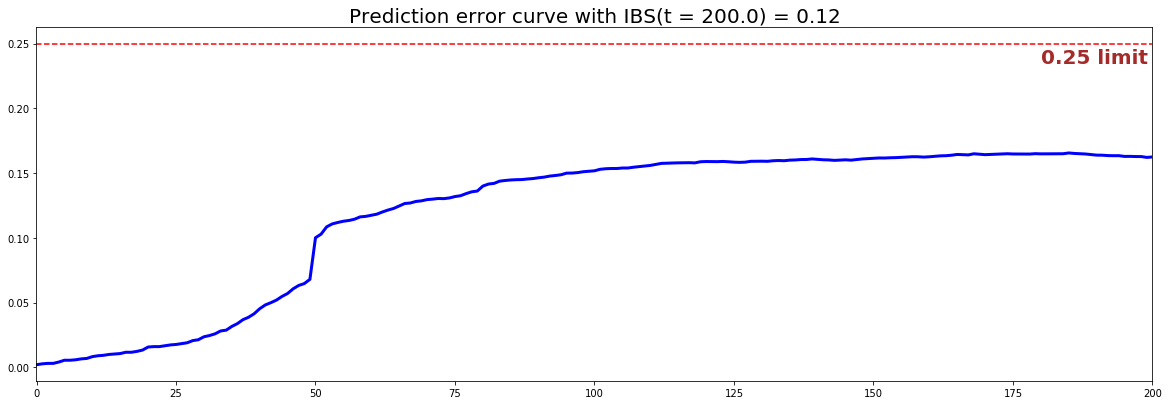

IBS: 0.1199
AUC: 0.8445


In [5]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd
import numpy as np

# Create empty dataframe for storing the results
num_trees_results = pd.DataFrame({'c_index':[0.751354],
                                  'mean_auc':[0.844710],
                                  'ibs':[0.118876],
                                  'num_trees':[50]})

# Test num_trees
for num_trees in [25,75,100]:
           
  print('FIT MODEL WITH PARAMETERS')
  print('num_trees: {0}'.format(num_trees))

  ## Build the model
  rsf = RandomSurvivalForestModel(num_trees=num_trees)
  rsf.fit(X_train, T_train, E_train,
          max_features="sqrt", max_depth=5, min_node_size=20)

  ## Evaluate model
  tmp_results = evaluate_model(rsf,X_train,T_train,E_train,X_test,T_test,E_test)
  tmp_results['num_trees'] = [num_trees]
  num_trees_results = pd.concat([num_trees_results, tmp_results], ignore_index=True)

In [12]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(num_trees_results, x='c_index', y='mean_auc',size='ibs',
                 hover_data=['num_trees'], color='num_trees',title='Score for num_trees')
fig.update_shapes(dict(xref='x', yref='y'))

fig.show()

## max_depth

Max number of levels in each decision tree

**Best Results: max_depth = 15**

FIT MODEL WITH PARAMETERS
max_depth: 2
c-index: 0.7164


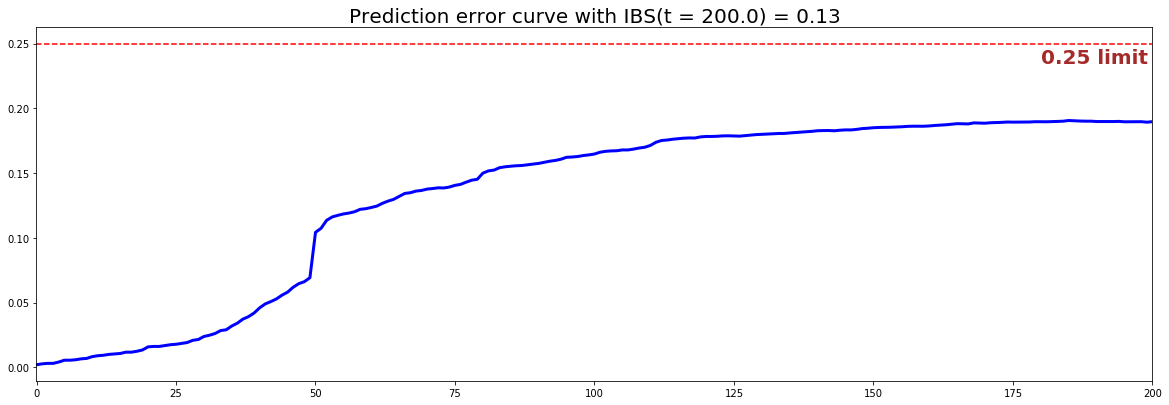

IBS: 0.1332
AUC: 0.8108
FIT MODEL WITH PARAMETERS
max_depth: 10


/home/marcosmedvescig/tesis/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




c-index: 0.7533


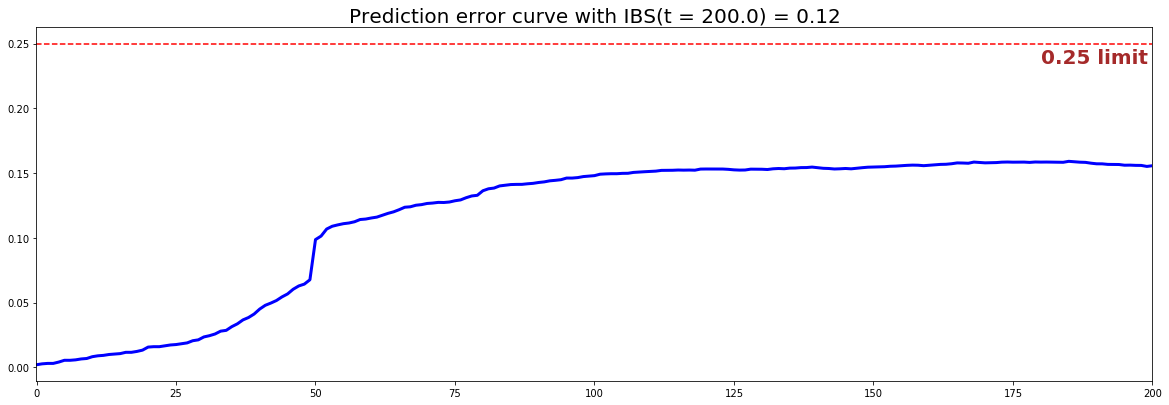

IBS: 0.1160
AUC: 0.8454
FIT MODEL WITH PARAMETERS
max_depth: 15


/home/marcosmedvescig/tesis/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




c-index: 0.7530


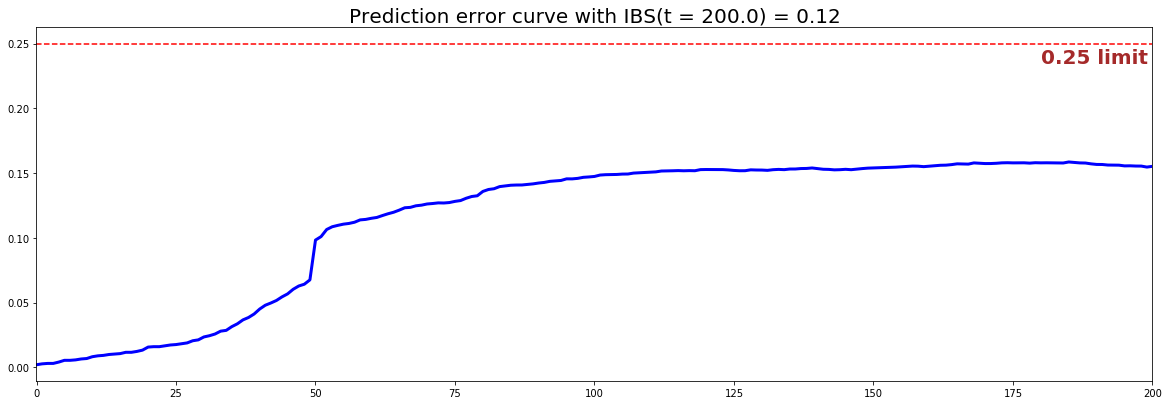

IBS: 0.1156
AUC: 0.8461


/home/marcosmedvescig/tesis/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [14]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd
# Create empty dataframe for storing the results

max_depth_results = pd.DataFrame({'c_index':[0.751995],
                                  'mean_auc':[0.845263],
                                  'ibs':[0.118645],
                                  'max_depth':[5]})

for max_depth in [2,10,15]:
           
  print('FIT MODEL WITH PARAMETERS')
  print('max_depth: {0}'.format(max_depth))

  ## Build the model
  rsf = RandomSurvivalForestModel(num_trees=75)
  rsf.fit(X_train, T_train, E_train,
          max_features="sqrt", max_depth=max_depth, min_node_size=20)

  ## Evaluate model
  tmp_results = evaluate_model(rsf,X_train,T_train,E_train,X_test,T_test,E_test)
  tmp_results['max_depth'] = [max_depth]
  max_depth_results = pd.concat([max_depth_results, tmp_results], ignore_index=True)

In [15]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(max_depth_results, x='c_index', y='mean_auc',size='ibs',
                 hover_data=['max_depth'], color='max_depth',title='Score for max_depth')
fig.update_shapes(dict(xref='x', yref='y'))

fig.show()

### min_node_size

Minimum number of samples required to be at a leaf node

**Best Results: min_node_size = 20**

FIT MODEL WITH PARAMETERS
min_node_size: 10
c-index: 0.7527


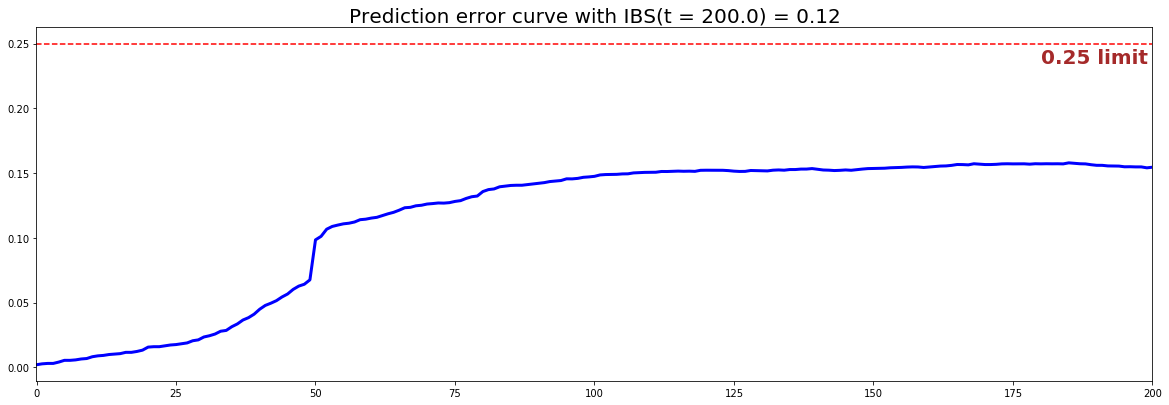

IBS: 0.1153
AUC: 0.8458
FIT MODEL WITH PARAMETERS
min_node_size: 15


/home/marcosmedvescig/tesis/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




c-index: 0.7516


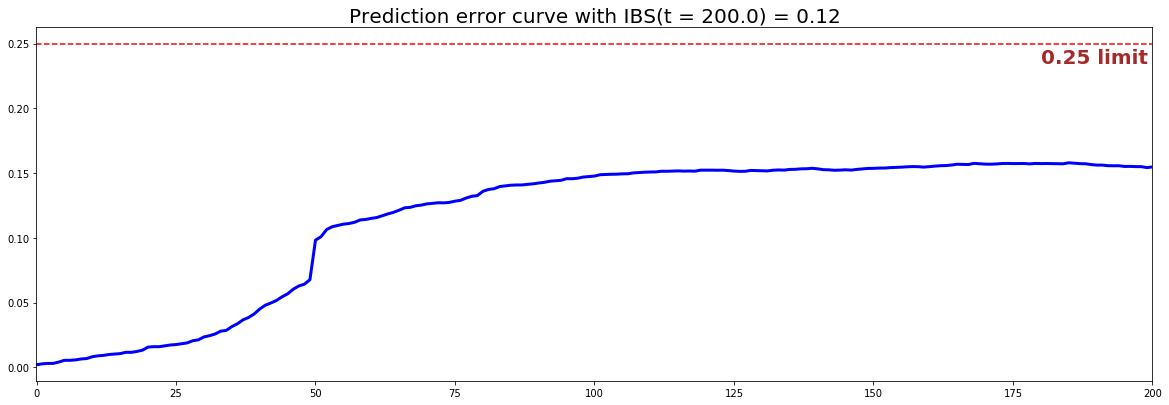

IBS: 0.1155
AUC: 0.8452
FIT MODEL WITH PARAMETERS
min_node_size: 25
c-index: 0.7527


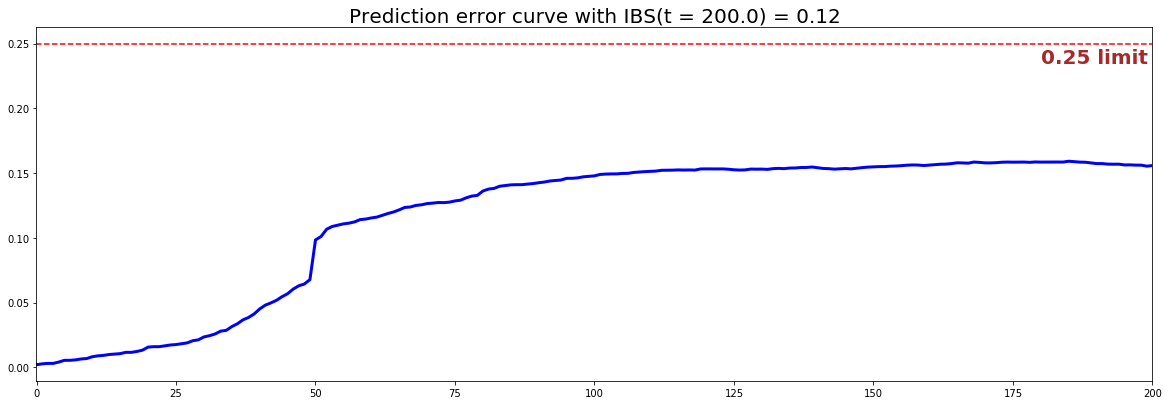

IBS: 0.1160
AUC: 0.8462


In [16]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd
# Create empty dataframe for storing the results

min_node_size_results = pd.DataFrame({'c_index':[0.752983],
                                    'mean_auc':[0.846072],
                                    'ibs':[0.115618],
                                    'min_node_size':[20]})


for min_node_size in [10,15,25]:
           
  print('FIT MODEL WITH PARAMETERS')
  print('min_node_size: {0}'.format(min_node_size))

  ## Build the model
  rsf = RandomSurvivalForestModel(num_trees=75)
  rsf.fit(X_train, T_train, E_train,
          max_features="sqrt", max_depth=15, min_node_size=min_node_size)

  ## Evaluate model
  tmp_results = evaluate_model(rsf,X_train,T_train,E_train,X_test,T_test,E_test)
  tmp_results['min_node_size'] = [min_node_size]
  min_node_size_results = pd.concat([min_node_size_results, tmp_results], ignore_index=True)

In [17]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(min_node_size_results, x='c_index', y='mean_auc',size='ibs',
                 hover_data=['min_node_size'], color='min_node_size',title='Score for min_node_size')
fig.update_shapes(dict(xref='x', yref='y'))

fig.show()

# Train final model

c-index: 0.7531


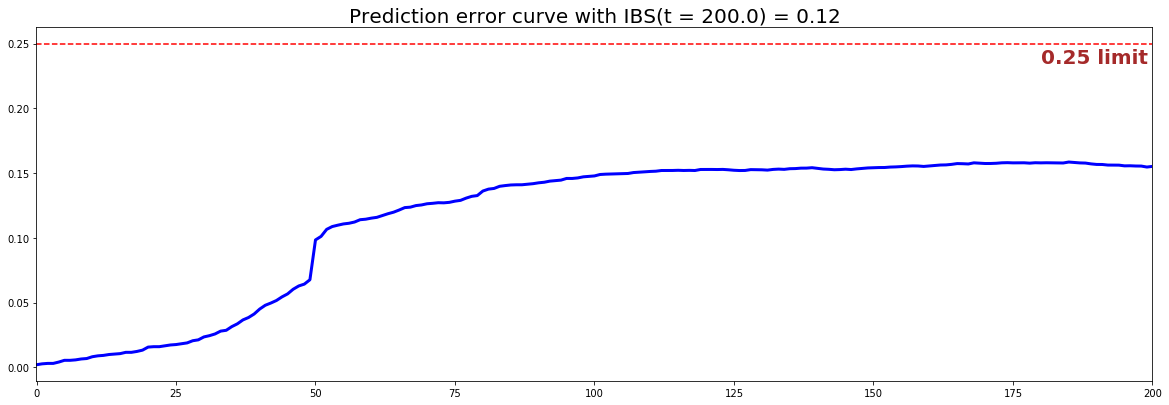

IBS: 0.1157
AUC: 0.8457


,c_index,ibs,mean_auc,model
0,0.753114,0.115737,0.845738,Final Model


In [18]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

## Build the model
rsf = RandomSurvivalForestModel(num_trees=75)
rsf.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=15, min_node_size=20)

## Evaluate model
final_model_results = evaluate_model(rsf,X_train,T_train,E_train,X_test,T_test,E_test)
final_model_results['model'] = ['Final Model']
final_model_results.head()

In [19]:
# Let's now save our model
from pysurvival.utils import save_model
save_model(rsf, 'model/churn_model_20200303.zip')

Saving the model to disk as model/churn_model_20200303.zip


# Compare final model score vs Benchmark

In [20]:
import pandas as pd

benchmark = pd.DataFrame({'c_index':[0.751354],
                          'mean_auc':[0.844710],
                          'ibs':[0.118876],
                          'model':'Benchmark'})

benchmark = pd.concat([benchmark,final_model_results],ignore_index=True)

benchmark.head()

/home/marcosmedvescig/tesis/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,c_index,ibs,mean_auc,model
0,0.751354,0.118876,0.844710,Benchmark
1,0.753114,0.115737,0.845738,Final Model


In [25]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(benchmark, x='c_index', y='mean_auc',size='ibs',
                 hover_data=['model'], color='model',
                 title='Score antes y despues de optimizar hiper parametros')
fig.update_shapes(dict(xref='x', yref='y'))

fig.show()